## Sentiment Analysis Using Model


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

In [4]:
# Load the Hugging Face tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('/content/drive/My Drive/distilbert_financial_sentiment_model')
# Load the saved fine-tuned distilbert model
distilbert_model = tf.keras.models.load_model('/content/drive/My Drive/distilbert_financial_sentiment_model')

In [5]:
# sentiment analysis of the news headlines of target stock
def sentiment_analysis(target_df):
    sequence_list = []
    output_list = []
    prediction_list =[]

    # tokenize each string of headline
    for i in range(len(target_df)):
        # input_sequence = tokenizer.encode(target_df.loc[i, 'headline'],
        #                                          truncation=True,
        #                                          padding=True,
        #                                          return_tensors="tf")
        input_sequence = tokenizer(
            target_df.loc[i, 'headline'],
            max_length=128,
            padding=True,
            truncation=True,
            return_tensors="tf"
        )
        # tf.convert_to_tensor(labels)

        sequence_list.append(input_sequence)
    # predict each sequence in logit
    for sequence in sequence_list:
        output_logit = distilbert_model(sequence)['logits']
        output_list.append(output_logit)
    # convert logits into predicted value 1(pos) or 0(neg)
    for idx in range(len(output_list)):
        # pred = tf.argmax(output_list[idx], axis=1).numpy()[0]
        probs = tf.nn.softmax(output_list[idx])
        predicted_class = tf.argmax(probs, axis=1)
        predicted_class_value = predicted_class.numpy()[0]
        prediction_list.append(predicted_class_value)

    target_df["sentiment"] = prediction_list
    return target_df

In [6]:
import pandas as pd

In [8]:
nvda_combined_news = pd.read_csv('nvidia_combined_news_cleaned_up.csv')

# Select a stock item for targeting
def targeting(data):
    target_df = data
    # sentiment analysis with the target data
    target_data = sentiment_analysis(target_df)
    # discern the time series of the target item for the next step (TS forecasting)
    unique_time = target_data.date.unique()
    print("\n", target_data[['headline', 'sentiment']].head(int(len(target_data)/5)))
    return target_data, unique_time

In [9]:
nvda_combined_news

,headline,date
0,Stock Market Today Dow heads fifth day losses ...,2024-11-20
1,Stanley Black Decker updates targets plus Nvid...,2024-11-20
2,Stocks fall Nvidia dips earnings report Live u...,2024-11-20
3,Stock Market News Today Dow Nasdaq Slip Invest...,2024-11-20
4,Nvidia On Deck Will Report Spark Rally Live Co...,2024-11-20
...,...,...
573,Not World War III But New Russian Nuclear Doct...,2024-11-19
574,Bitcoin Dogecoin Gain Ethereum Drops As BlackR...,2024-11-19
575,Dan Ives Expects Drop The Mic Performance Tomo...,2024-11-19
576,Nvidia Microstrategy Apollo Global Management ...,2024-11-19


In [10]:
nvda_combined_news.columns

Index(['headline', 'date'], dtype='object')

In [11]:
target_data, unique_time = targeting(nvda_combined_news)


                                               headline  sentiment
0    Stock Market Today Dow heads fifth day losses ...          0
1    Stanley Black Decker updates targets plus Nvid...          1
2    Stocks fall Nvidia dips earnings report Live u...          0
3    Stock Market News Today Dow Nasdaq Slip Invest...          0
4    Nvidia On Deck Will Report Spark Rally Live Co...          1
..                                                 ...        ...
187  Marjorie Taylor Greene Boosts Stock Portfolio ...          1
188  Morgan Stanley Reiterates Overweight NVIDIA Ma...          0
189  Jim Cramer Likes Reddit Very Much Calls Accent...          1
190  Top 10 Trending Stocks On WallStreetBets As Of...          1
191  Market Clubhouse Morning Memo October 10th 202...          1

[192 rows x 2 columns]


In [12]:
import matplotlib.pyplot as plt
import numpy as np
from dateutil.relativedelta import relativedelta
import pandas_datareader as pdr
from datetime import datetime

In [80]:
pip install pandas-datareader

In [13]:
nvda_stock_data = pd.read_csv('nvda_stock_data.csv')
print(nvda_stock_data)
print(nvda_stock_data['date'].dtype)
# Convert the 'date' column to datetime
nvda_stock_data['date'] = pd.to_datetime(nvda_stock_data['date'])

# Check the new dtype
print(nvda_stock_data['date'].dtype)

            date   Adj Close       Close        High         Low        Open  \
0     2020-01-02    5.972710    5.997750    5.997750    5.918000    5.968750   
1     2020-01-03    5.877111    5.901750    5.945750    5.852500    5.877500   
2     2020-01-06    5.901757    5.926500    5.931750    5.781750    5.808000   
3     2020-01-07    5.973209    5.998250    6.044250    5.909750    5.955000   
4     2020-01-08    5.984411    6.009500    6.051000    5.953750    5.994000   
...          ...         ...         ...         ...         ...         ...   
1224  2024-11-12  148.279770  148.289993  149.649994  146.009995  146.779999   
1225  2024-11-13  146.259918  146.270004  149.330002  145.899994  149.070007   
1226  2024-11-14  146.749878  146.759995  149.000000  145.550003  147.639999   
1227  2024-11-15  141.970215  141.979996  145.240005  140.080002  144.869995   
1228  2024-11-18  140.140335  140.149994  141.550003  137.149994  139.500000   

         Volume  
0     237536000  
1  

In [14]:
# Plot daily stock data for target stock, NASDAQ, S&P500
def plot_ticker(df, start, end):

    plt.figure(figsize=(14, 8))
    #----------Stock Prices Plot----------
    plt.plot(df.date, df["High"], label = 'High')
    plt.plot(df.date, df["Low"], label = 'Low')
    plt.plot(df.date, df["Open"], label = 'Open')
    plt.plot(df.date, df["Close"], label = 'Close')
    plt.plot(df.date, df["Adj Close"], label = 'Adj Close')

    plt.xticks(size=8)
    plt.yticks(size=8)

    plt.ylabel('Price($)', {'color': 'gray', 'fontsize':13})

    plt.title('NVDA', size=14, fontweight='bold')

    # Plotting the horizontal line for min & max values along with the adj close prices
    max_price = np.round(np.max(df['Adj Close']),3)
    min_price = np.round(np.min(df['Adj Close']),3)
    plt.axhline(max_price, color='r', linestyle='dashed')
    plt.axhline(min_price, color='b', linestyle='dashed')

    # coordinate for the text position (x-axis)
    coord = datetime.strptime(end,'%Y%m%d')
    coord = coord + relativedelta(days=1)
    # y-axis = max and min prices + 1
    plt.text(coord, max_price+1, 'AdjClose Max = $'+str(max_price), size=10, color='r')
    plt.text(coord, min_price+1, 'AdjClose Min = $'+str(min_price), size=10, color='b')

    plt.legend()
    plt.grid(True)

    plt.show()

In [16]:
from datetime import datetime

In [15]:
def ticker_info():

    end_date = input("Set a date (yyyymmdd):")
    cnvtDate = datetime.strptime(end_date, "%Y%m%d")
    gap = input("Time Gap (days):")
    adjDate = cnvtDate - relativedelta(days=int(gap))
    start_date = adjDate.strftime('%Y%m%d')

    symbol = input("Symbol:")

    stock_df = nvda_stock_data

    stock_df = stock_df[(stock_df['date'] >= start_date) & (stock_df['date'] <= end_date)]


    stock = stock_df[stock_df.columns.difference(["Volume"])]

    plot_ticker(stock, start_date, end_date)
    # AllInOne_df = merge_ticker_senti(target_data, ticker_df)
    # AllInOne_df = pd.get_dummies(AllInOne_df,columns=['sentiment'], drop_first = True)

    # return AllInOne_df

Set a date (yyyymmdd):20241231
Time Gap (days):100
Symbol:NVDA


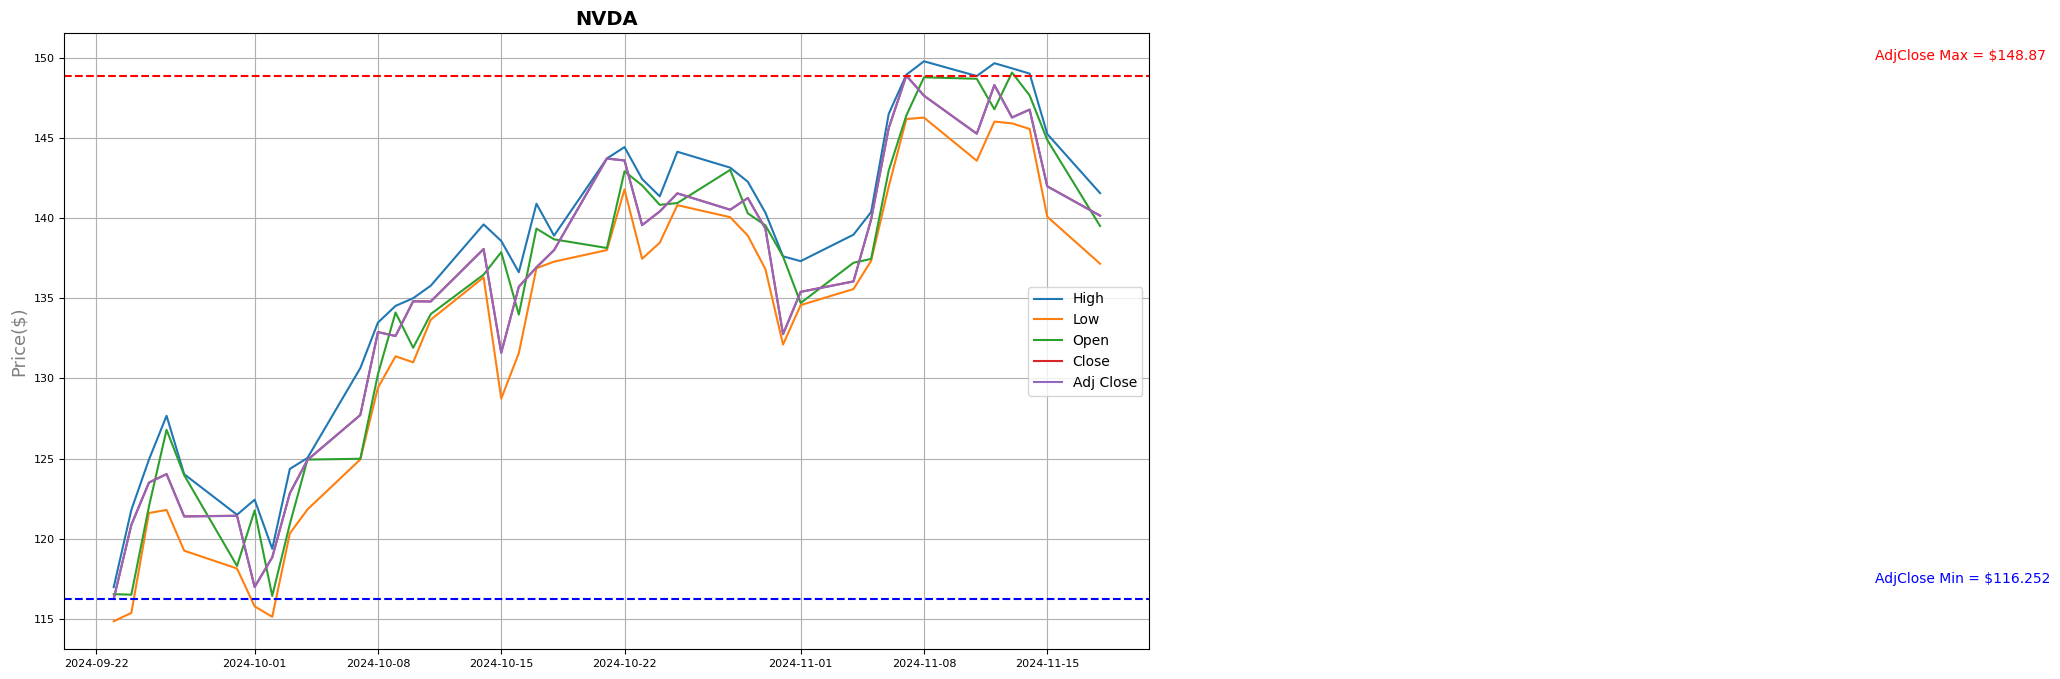

In [17]:
ticker_info()

In [18]:
target_data

,headline,date,sentiment
0,Stock Market Today Dow heads fifth day losses ...,2024-11-20,0
1,Stanley Black Decker updates targets plus Nvid...,2024-11-20,1
2,Stocks fall Nvidia dips earnings report Live u...,2024-11-20,0
3,Stock Market News Today Dow Nasdaq Slip Invest...,2024-11-20,0
4,Nvidia On Deck Will Report Spark Rally Live Co...,2024-11-20,1
...,...,...,...
573,Not World War III But New Russian Nuclear Doct...,2024-11-19,0
574,Bitcoin Dogecoin Gain Ethereum Drops As BlackR...,2024-11-19,0
575,Dan Ives Expects Drop The Mic Performance Tomo...,2024-11-19,0
576,Nvidia Microstrategy Apollo Global Management ...,2024-11-19,1


In [38]:
def combine_sentiment_with_stock_data(sentiment_data, stock_data):
    # Average the sentiment if there are multiple sentiments per date
    sentiment_data_by_time = sentiment_data.groupby(["date"]).mean('sentiment')
    sentiment_data_by_time['sentiment'] = sentiment_data_by_time['sentiment'].apply(lambda x: "positive" if x > 0.5 else ("negative" if x < 0.5 else "neutral"))
    # merge the grouped sentiment dataframe with the ticker dataframe which will be the input data for LSTM RNN
    stock_data = stock_data.set_index('date')
    sentiment_data_by_time.index = pd.to_datetime(sentiment_data_by_time.index)
    print(sentiment_data_by_time.index.dtype)
    print(stock_data.index.dtype)
    combined_df = stock_data.merge(sentiment_data_by_time, how='inner', left_index=True, right_index=True)
    return combined_df


In [48]:
combined_df = combine_sentiment_with_stock_data(target_data, nvda_stock_data)
print(combined_df)
# combined_df.to_csv('./combined_sentiment_and_nvda_stock_data.csv')


datetime64[ns]
datetime64[ns]
             Adj Close       Close        High         Low        Open  \
date                                                                     
2020-04-16    7.341130    7.367500    7.475000    7.163750    7.177000   
2020-05-22    8.993945    9.026250    9.093000    8.713250    8.825250   
2021-02-18   14.791459   14.829000   14.873250   14.575000   14.729000   
2021-03-30   12.843596   12.871750   12.975250   12.705000   12.842000   
2021-05-26   15.665660   15.700000   15.793750   15.586250   15.734250   
...                ...         ...         ...         ...         ...   
2024-11-12  148.279770  148.289993  149.649994  146.009995  146.779999   
2024-11-13  146.259918  146.270004  149.330002  145.899994  149.070007   
2024-11-14  146.749878  146.759995  149.000000  145.550003  147.639999   
2024-11-15  141.970215  141.979996  145.240005  140.080002  144.869995   
2024-11-18  140.140335  140.149994  141.550003  137.149994  139.500000   

       

In [40]:
from sklearn.preprocessing import MinMaxScaler


In [49]:
combined_df = pd.read_csv("combined_sentiment_and_nvda_stock_data.csv", index_col = 0)

combined_df = pd.get_dummies(combined_df,columns=['sentiment'], drop_first = True)
print(combined_df)
combined_df = combined_df[['High', 'Low', 'Open',
                 'Close', 'Volume', 'Adj Close',
                 'sentiment_neutral', 'sentiment_positive']]

# Standardize input data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df = scaler.fit_transform(combined_df)

# train test split
train_size = int(len(scaled_df)*0.8)
test_size = len(scaled_df)-train_size
train_df, test_df = scaled_df[0:train_size], scaled_df[train_size:]
print(len(scaled_df),"=",train_size,"+",test_size)

             Adj Close       Close        High         Low        Open  \
date                                                                     
2020-04-16    7.341130    7.367500    7.475000    7.163750    7.177000   
2020-05-22    8.993945    9.026250    9.093000    8.713250    8.825250   
2021-02-18   14.791459   14.829000   14.873250   14.575000   14.729000   
2021-03-30   12.843596   12.871750   12.975250   12.705000   12.842000   
2021-05-26   15.665660   15.700000   15.793750   15.586250   15.734250   
...                ...         ...         ...         ...         ...   
2024-11-12  148.279770  148.289993  149.649994  146.009995  146.779999   
2024-11-13  146.259918  146.270004  149.330002  145.899994  149.070007   
2024-11-14  146.749878  146.759995  149.000000  145.550003  147.639999   
2024-11-15  141.970215  141.979996  145.240005  140.080002  144.869995   
2024-11-18  140.140335  140.149994  141.550003  137.149994  139.500000   

                Volume  sentiment_neu

In [50]:
# assign X and Y based on time steps
def assign(data, timestep = None):
    X, y = [],[]

    if timestep == None:
        default_timestep = 10
        for i in range(len(data)-default_timestep-1):
            values_X = data[i:(i+default_timestep)]
            values_y = data[i+default_timestep,5]

            X.append(values_X)
            y.append(values_y)

    else:
        for i in range(len(data)-timestep-1):
            values_X = data[i:(i+timestep)]
            values_y = data[i+timestep,5]

            X.append(values_X)
            y.append(values_y)

    return np.array(X), np.array(y)

In [51]:
timestep=5

X_train, y_train = assign(train_df, timestep)
X_test, y_test = assign(test_df, timestep)

y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(65, 5, 8) (65, 1)
(12, 5, 8) (12, 1)


In [53]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [70]:
# LSTM Params
# Activation: tanh
# Recurrent Activation: sigmoid
# Dropout: 0 (none)
# Output D: 50 (shape of (batch_size, timesteps, 50))

# Output Dense Params
# Activation: Linear
# Output D: 1(single continuous value)
config = {'loss':'mean_squared_error',
          'optimizer':'adam',
          'epoch':5,
          'batch_size':8,
          'metric':'mse',
          'verbose':1}

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(y_train.shape[1]))

model.compile(loss = config['loss'],
              optimizer = config['optimizer'],
              metrics=[config['metric']])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 5, 50)               │          11,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 5, 50)               │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,251 (204.11 KB)

 Trainable params: 52,251 (204.11 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
from IPython.display import clear_output


In [71]:
# customized callback
class PlotLearning(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.metric = []
        self.val_metric = []

        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.metric.append(logs.get(config['metric']))
        self.val_metric.append(logs.get('val_'+config['metric']))
        self.i += 1

        fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        fig.set_size_inches(10.5, 7.5)
        fig.suptitle('Processing',size = 20)
        clear_output(wait=True)
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="Train Loss")
        ax1.plot(self.x, self.val_losses, label="Valid Loss")
        ax1.legend()


        ax2.plot(self.x, self.metric, label="Train_"+config['metric'])
        ax2.plot(self.x, self.val_metric, label="Valid_"+config['metric'])
        ax2.legend()

        plt.show();

plot = PlotLearning()

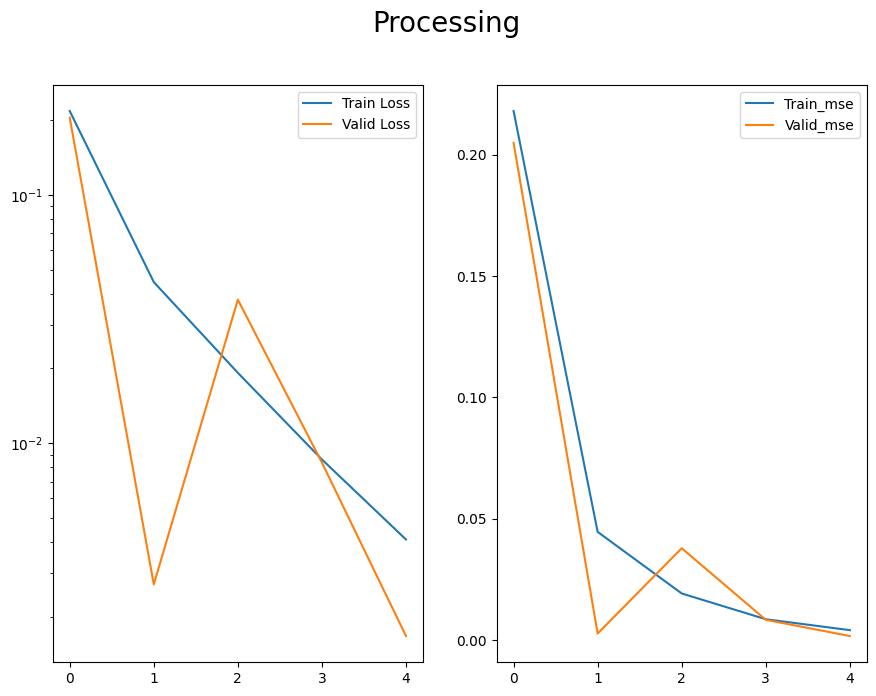

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0017 - val_mse: 0.0017


In [72]:
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    epochs=config["epoch"],
                    batch_size=config["batch_size"],
                    verbose=config['verbose'],
                    callbacks=[plot])

## Evaluation

In [73]:
# Predict train & test sets
train_pred = model.predict(X_train)
train_pred_copies = np.repeat(train_pred, train_df.shape[1], axis=1) # Adjust the shape of the output
train_pred_inverse = scaler.inverse_transform(train_pred_copies)[:,0] # Scale back the normalized output

y_train_copies = np.repeat(y_train, train_df.shape[1], axis=1) # Adjust the shape of the output
y_train_inverse = scaler.inverse_transform(y_train_copies)[:,0] # Scale back the normalized output

test_pred = model.predict(X_test)
test_pred_copies = np.repeat(test_pred, test_df.shape[1], axis=1) # Adjust the shape of the output
test_pred_inverse = scaler.inverse_transform(test_pred_copies)[:,0] # Scale back the normalized output

y_test_copies = np.repeat(y_test, test_df.shape[1], axis=1) # Adjust the shape of the output
y_test_inverse = scaler.inverse_transform(y_test_copies)[:,0] # Scale back the normalized output

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [81]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [82]:
# Root Mean Squared Error for train & test sets
rmse_train = math.sqrt(mean_squared_error(y_train_inverse, train_pred_inverse))
rmse_test = math.sqrt(mean_squared_error(y_test_inverse, test_pred_inverse))
print('RMSE for train: %0.2f' % rmse_train)
print('RMSE for test: %0.2f' % rmse_test)

# Mean Absolute Percentage Error
mape_train = math.sqrt(mean_absolute_percentage_error(y_train_inverse, train_pred_inverse))
mape_test = math.sqrt(mean_absolute_percentage_error(y_test_inverse, test_pred_inverse))
print('MAPE for train: %0.2f' % mape_train)
print('MAPE for test: %0.2f' % mape_test)

RMSE for train: 9.65
RMSE for test: 5.82
MAPE for train: 0.40
MAPE for test: 0.19


In [93]:
import matplotlib.dates as mdates


Exception ignored in: <function _xla_gc_callback at 0x7a6958d639a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


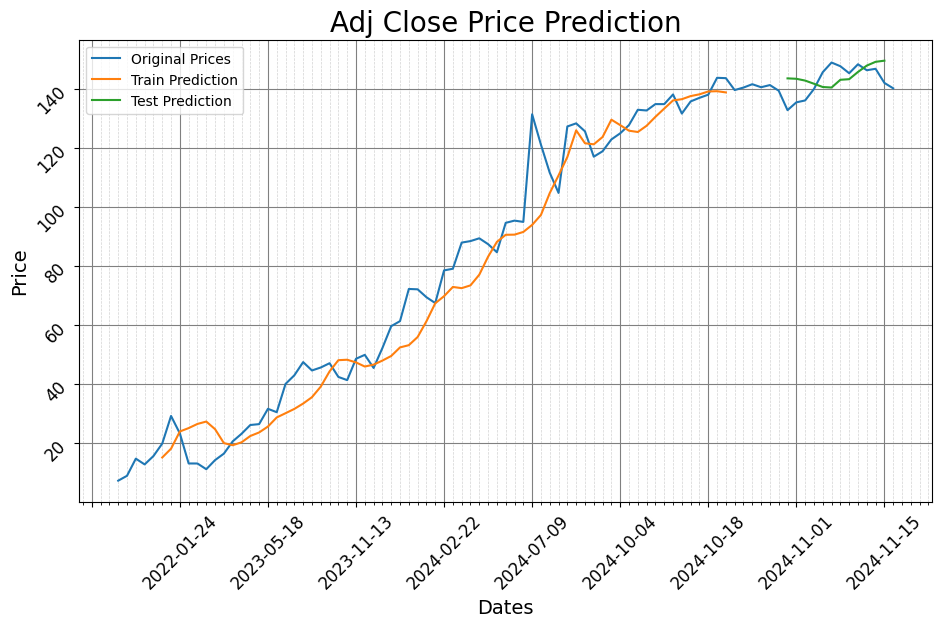

In [99]:
# create an array for train prediction values
timesteps = 5
train_prediction_array = np.empty_like(scaled_df[:,5])
train_prediction_array[:,] = np.nan
train_prediction_array[timesteps : len(train_pred_inverse)+timesteps, ] = train_pred_inverse

# create an array for test prediction values
test_prediction_array = np.empty_like(scaled_df[:,5])
test_prediction_array[:,] = np.nan
test_prediction_array[len(y_train)+(timesteps*2)+1 : len(scaled_df)-1, ] = test_pred_inverse

# original adj close price
orig_price = scaler.inverse_transform(scaled_df)[:, 5]

# plot baseline and predictions
plt.figure(figsize=(11,6))

plt.xticks(rotation=45, size=12)
plt.yticks(rotation=45, size=12)

ax = plt.gca()

ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))  # Major tick labels every 10 days
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=5))  # Minor ticks for all days

# Display grid lines for both major and minor ticks
ax.grid(which='major', color='gray', linestyle='-', linewidth=0.8)  # Major grid
ax.grid(which='minor', color='lightgray', linestyle='--', linewidth=0.5)  # Minor grid


plt.xlabel('Dates', size = 14)
plt.ylabel('Price', size = 14)
plt.title('Adj Close Price Prediction', size=20)

plt.plot(combined_df.index, orig_price, label = "Original Prices")
plt.plot(combined_df.index, train_prediction_array, label = "Train Prediction")
plt.plot(combined_df.index, test_prediction_array, label = "Test Prediction")

plt.grid(True)
plt.legend()
plt.show()